In [1]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pathlib import Path
from itertools import product

from utilities.nn_utils import *
from IPython.display import display, Markdown

In [2]:
data_path = Path("/Users/adamsulik/Workspace/qrt_datachallenge/data")

output_storage_path = data_path.parent / 'outputs' / 'nn_approach'
output_storage_path.mkdir(exist_ok=True, parents=True)

# Read data

In [3]:
x_train = pd.read_csv(data_path / 'x_train_Lafd4AH.csv', index_col='ID')
y_train = pd.read_csv(data_path / 'y_train_JQU4vbI.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv(data_path / 'x_test_c7ETL4q.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


# Feature engineering

In [4]:
def column2onehot(x_table, column, ohencoder=None):
    if ohencoder is None:
        ohencoder = OneHotEncoder().fit(x_table[column].values.reshape(-1, 1))
    ohe_values = ohencoder.transform(x_table[column].values.reshape(-1, 1)).toarray()
    column_names = [f'{column}_ohe_{i}' for i in range(ohe_values.shape[1])]
    ohe_df = pd.DataFrame(index=x_table.index, columns=column_names)
    ohe_df.iloc[:] = ohe_values
    return ohe_df, ohencoder

# Run the training

In [5]:
SEED = 42
NUM_WORKERS = 10
PRINT_EVERY = 2
# device = None
device = 'cpu'

backdates = [5, 10, 15, 20]

rel_cat_cols = ['SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY']
split_type='date'

for backdate_range, used_oh_col in product(backdates, rel_cat_cols):
    experiment_name = f'oh-{used_oh_col}_daysback-{backdate_range}'
    display(Markdown('---'))
    display(Markdown(f'# Experiment: {experiment_name}'))
    display(Markdown(f'OH encoding: {used_oh_col}'))
    display(Markdown(f'Looking back for {backdate_range} dates\n'))
    
    chosen_field_oh, ohencoder = column2onehot(train, used_oh_col)
    
    numerical_columns = [f'RET_{i+1}' for i in range(backdate_range)] + [f'VOLUME_{i+1}' for i in range(backdate_range)]
    oh_columns = list(chosen_field_oh.columns)
    dates_arr = x_train['DATE']
    x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)
    x_df = x_df[numerical_columns + oh_columns] # assert order
    
    X = x_df.values
    Y = train['RET'].astype(int).values
    
    # Standarize numerical values
    scaler = StandardScaler().fit(X[:, :len(numerical_columns)])
    X[:, :len(numerical_columns)] = scaler.transform(X[:, :len(numerical_columns)])
    
    # run k-fold cv
    cv_results = run_k_fold_training(X, Y, random_seed=SEED, num_workers=NUM_WORKERS, device=device,
                                     split_type='date', date_array=dates_arr, print_every_epoch=PRINT_EVERY)
    
    # store cross validation results
    cv_results = pd.DataFrame(cv_results).set_index('fold')
    cv_results.to_csv(output_storage_path / f'{experiment_name}.csv')
    
    avg_acc = cv_results['accuracy'].mean()
    std_acc = cv_results['accuracy'].std()
    
    upper_bound_acc = avg_acc + std_acc
    lower_bound_acc = avg_acc - std_acc
    
    print(f'Accuracy: {avg_acc:.5f} [{lower_bound_acc:.5f}; {upper_bound_acc:.5f}] (+- {std_acc:.6f}), based on 4 kfolds')
    

---

# Experiment: oh-SECTOR_daysback-5

OH encoding: SECTOR

Looking back for 5 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on cpu

Fold 1/4
Train/Val ratio: 3.09
13:42:56	  -- Epoch 2: Training Loss = 0.6926 | Training Accuracy = 0.5140 | Validation Accuracy = 0.5081
13:43:17	  -- Epoch 4: Training Loss = 0.6922 | Training Accuracy = 0.5167 | Validation Accuracy = 0.5097
13:43:37	  -- Epoch 6: Training Loss = 0.6921 | Training Accuracy = 0.5190 | Validation Accuracy = 0.5158
13:43:59	  -- Epoch 8: Training Loss = 0.6920 | Training Accuracy = 0.5190 | Validation Accuracy = 0.5190
13:44:19	  -- Epoch 10: Training Loss = 0.6919 | Training Accuracy = 0.5185 | Validation Accuracy = 0.5142
13:44:40	  -- Epoch 12: Training Loss = 0.6917 | Training Accuracy = 0.5213 | Validation Accuracy = 0.5155
13:45:04	  -- Epoch 14: Training Loss = 0.6916 | Training Accuracy = 0.5218 | Validation Accuracy = 0.5141
13:45:25	  -- Epoch 16: Training Loss = 0.6916 | Training Accuracy = 0.5227 | Validation Accuracy = 0.5164
13:45:45	  -- Epoch 18: Training Loss = 0.6913 | Training Accuracy = 0.5229 | Validation Accuracy = 

---

# Experiment: oh-INDUSTRY_GROUP_daysback-5

OH encoding: INDUSTRY_GROUP

Looking back for 5 dates


Training on cpu

Fold 1/4
Train/Val ratio: 3.09


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


14:17:33	  -- Epoch 2: Training Loss = 0.6926 | Training Accuracy = 0.5145 | Validation Accuracy = 0.5005
14:17:54	  -- Epoch 4: Training Loss = 0.6922 | Training Accuracy = 0.5179 | Validation Accuracy = 0.5100
14:18:16	  -- Epoch 6: Training Loss = 0.6920 | Training Accuracy = 0.5200 | Validation Accuracy = 0.5163
14:18:37	  -- Epoch 8: Training Loss = 0.6917 | Training Accuracy = 0.5217 | Validation Accuracy = 0.5170
14:18:59	  -- Epoch 10: Training Loss = 0.6914 | Training Accuracy = 0.5238 | Validation Accuracy = 0.5169
14:19:20	  -- Epoch 12: Training Loss = 0.6914 | Training Accuracy = 0.5248 | Validation Accuracy = 0.5134
14:19:41	  -- Epoch 14: Training Loss = 0.6914 | Training Accuracy = 0.5226 | Validation Accuracy = 0.5167
14:20:02	  -- Epoch 16: Training Loss = 0.6911 | Training Accuracy = 0.5253 | Validation Accuracy = 0.5135
14:20:24	  -- Epoch 18: Training Loss = 0.6911 | Training Accuracy = 0.5233 | Validation Accuracy = 0.5168
14:20:45	  -- Epoch 20: Training Loss = 0

---

# Experiment: oh-INDUSTRY_daysback-5

OH encoding: INDUSTRY

Looking back for 5 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on cpu

Fold 1/4
Train/Val ratio: 3.09
14:55:36	  -- Epoch 2: Training Loss = 0.6925 | Training Accuracy = 0.5147 | Validation Accuracy = 0.5125
14:55:57	  -- Epoch 4: Training Loss = 0.6919 | Training Accuracy = 0.5200 | Validation Accuracy = 0.5104
14:56:19	  -- Epoch 6: Training Loss = 0.6917 | Training Accuracy = 0.5208 | Validation Accuracy = 0.4994
14:56:40	  -- Epoch 8: Training Loss = 0.6915 | Training Accuracy = 0.5241 | Validation Accuracy = 0.5153
14:57:01	  -- Epoch 10: Training Loss = 0.6913 | Training Accuracy = 0.5244 | Validation Accuracy = 0.5125
14:57:22	  -- Epoch 12: Training Loss = 0.6912 | Training Accuracy = 0.5260 | Validation Accuracy = 0.5151
14:57:44	  -- Epoch 14: Training Loss = 0.6910 | Training Accuracy = 0.5263 | Validation Accuracy = 0.5155
14:58:05	  -- Epoch 16: Training Loss = 0.6907 | Training Accuracy = 0.5276 | Validation Accuracy = 0.5145
14:58:27	  -- Epoch 18: Training Loss = 0.6907 | Training Accuracy = 0.5271 | Validation Accuracy = 

---

# Experiment: oh-SECTOR_daysback-10

OH encoding: SECTOR

Looking back for 10 dates


Training on cpu

Fold 1/4
Train/Val ratio: 3.09


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


15:30:31	  -- Epoch 2: Training Loss = 0.6925 | Training Accuracy = 0.5143 | Validation Accuracy = 0.5093
15:30:52	  -- Epoch 4: Training Loss = 0.6921 | Training Accuracy = 0.5182 | Validation Accuracy = 0.5041
15:31:14	  -- Epoch 6: Training Loss = 0.6917 | Training Accuracy = 0.5204 | Validation Accuracy = 0.5068
15:31:35	  -- Epoch 8: Training Loss = 0.6915 | Training Accuracy = 0.5216 | Validation Accuracy = 0.5095
15:31:57	  -- Epoch 10: Training Loss = 0.6913 | Training Accuracy = 0.5229 | Validation Accuracy = 0.5096
15:32:19	  -- Epoch 12: Training Loss = 0.6912 | Training Accuracy = 0.5226 | Validation Accuracy = 0.5140
15:32:39	  -- Epoch 14: Training Loss = 0.6910 | Training Accuracy = 0.5248 | Validation Accuracy = 0.5075
15:33:00	  -- Epoch 16: Training Loss = 0.6908 | Training Accuracy = 0.5255 | Validation Accuracy = 0.5063
15:33:21	  -- Epoch 18: Training Loss = 0.6907 | Training Accuracy = 0.5258 | Validation Accuracy = 0.5143
15:33:42	  -- Epoch 20: Training Loss = 0

---

# Experiment: oh-INDUSTRY_GROUP_daysback-10

OH encoding: INDUSTRY_GROUP

Looking back for 10 dates


Training on cpu

Fold 1/4
Train/Val ratio: 3.09


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


17:46:07	  -- Epoch 2: Training Loss = 0.6925 | Training Accuracy = 0.5147 | Validation Accuracy = 0.5104
17:46:28	  -- Epoch 4: Training Loss = 0.6918 | Training Accuracy = 0.5203 | Validation Accuracy = 0.5088
17:46:48	  -- Epoch 6: Training Loss = 0.6915 | Training Accuracy = 0.5223 | Validation Accuracy = 0.5136
17:47:09	  -- Epoch 8: Training Loss = 0.6912 | Training Accuracy = 0.5262 | Validation Accuracy = 0.5129
17:47:30	  -- Epoch 10: Training Loss = 0.6909 | Training Accuracy = 0.5270 | Validation Accuracy = 0.5167
17:47:51	  -- Epoch 12: Training Loss = 0.6908 | Training Accuracy = 0.5272 | Validation Accuracy = 0.5123
17:48:12	  -- Epoch 14: Training Loss = 0.6907 | Training Accuracy = 0.5273 | Validation Accuracy = 0.5112
17:48:32	  -- Epoch 16: Training Loss = 0.6903 | Training Accuracy = 0.5293 | Validation Accuracy = 0.5065
17:48:53	  -- Epoch 18: Training Loss = 0.6903 | Training Accuracy = 0.5284 | Validation Accuracy = 0.5114
17:49:14	  -- Epoch 20: Training Loss = 0

---

# Experiment: oh-INDUSTRY_daysback-10

OH encoding: INDUSTRY

Looking back for 10 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on cpu

Fold 1/4
Train/Val ratio: 3.09
18:54:17	  -- Epoch 2: Training Loss = 0.6924 | Training Accuracy = 0.5169 | Validation Accuracy = 0.5125
18:54:39	  -- Epoch 4: Training Loss = 0.6917 | Training Accuracy = 0.5233 | Validation Accuracy = 0.5166
18:55:01	  -- Epoch 6: Training Loss = 0.6913 | Training Accuracy = 0.5255 | Validation Accuracy = 0.5134
18:55:23	  -- Epoch 8: Training Loss = 0.6910 | Training Accuracy = 0.5263 | Validation Accuracy = 0.5107
18:55:46	  -- Epoch 10: Training Loss = 0.6906 | Training Accuracy = 0.5287 | Validation Accuracy = 0.5154
18:56:08	  -- Epoch 12: Training Loss = 0.6903 | Training Accuracy = 0.5310 | Validation Accuracy = 0.5127
18:56:30	  -- Epoch 14: Training Loss = 0.6901 | Training Accuracy = 0.5313 | Validation Accuracy = 0.5130
18:56:53	  -- Epoch 16: Training Loss = 0.6900 | Training Accuracy = 0.5325 | Validation Accuracy = 0.5119
18:57:15	  -- Epoch 18: Training Loss = 0.6898 | Training Accuracy = 0.5320 | Validation Accuracy = 

---

# Experiment: oh-SECTOR_daysback-15

OH encoding: SECTOR

Looking back for 15 dates


Training on cpu

Fold 1/4
Train/Val ratio: 3.09


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


19:31:55	  -- Epoch 2: Training Loss = 0.6923 | Training Accuracy = 0.5173 | Validation Accuracy = 0.5115
19:32:16	  -- Epoch 4: Training Loss = 0.6918 | Training Accuracy = 0.5216 | Validation Accuracy = 0.5109
19:32:38	  -- Epoch 6: Training Loss = 0.6913 | Training Accuracy = 0.5243 | Validation Accuracy = 0.5134
19:32:59	  -- Epoch 8: Training Loss = 0.6911 | Training Accuracy = 0.5251 | Validation Accuracy = 0.5130
19:33:20	  -- Epoch 10: Training Loss = 0.6908 | Training Accuracy = 0.5268 | Validation Accuracy = 0.5150
19:33:43	  -- Epoch 12: Training Loss = 0.6903 | Training Accuracy = 0.5275 | Validation Accuracy = 0.5072
19:34:04	  -- Epoch 14: Training Loss = 0.6904 | Training Accuracy = 0.5272 | Validation Accuracy = 0.5112
19:34:25	  -- Epoch 16: Training Loss = 0.6901 | Training Accuracy = 0.5285 | Validation Accuracy = 0.5110
19:34:46	  -- Epoch 18: Training Loss = 0.6902 | Training Accuracy = 0.5295 | Validation Accuracy = 0.5124
19:35:08	  -- Epoch 20: Training Loss = 0

---

# Experiment: oh-INDUSTRY_GROUP_daysback-15

OH encoding: INDUSTRY_GROUP

Looking back for 15 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on cpu

Fold 1/4
Train/Val ratio: 3.09
20:08:42	  -- Epoch 2: Training Loss = 0.6923 | Training Accuracy = 0.5178 | Validation Accuracy = 0.5134
20:09:05	  -- Epoch 4: Training Loss = 0.6915 | Training Accuracy = 0.5232 | Validation Accuracy = 0.5149
20:09:27	  -- Epoch 6: Training Loss = 0.6912 | Training Accuracy = 0.5261 | Validation Accuracy = 0.5125
20:09:49	  -- Epoch 8: Training Loss = 0.6909 | Training Accuracy = 0.5267 | Validation Accuracy = 0.5005
20:10:12	  -- Epoch 10: Training Loss = 0.6904 | Training Accuracy = 0.5301 | Validation Accuracy = 0.5087
20:10:35	  -- Epoch 12: Training Loss = 0.6903 | Training Accuracy = 0.5295 | Validation Accuracy = 0.5100
20:10:57	  -- Epoch 14: Training Loss = 0.6902 | Training Accuracy = 0.5308 | Validation Accuracy = 0.5123
20:11:19	  -- Epoch 16: Training Loss = 0.6899 | Training Accuracy = 0.5313 | Validation Accuracy = 0.5117
20:11:41	  -- Epoch 18: Training Loss = 0.6898 | Training Accuracy = 0.5317 | Validation Accuracy = 

---

# Experiment: oh-INDUSTRY_daysback-15

OH encoding: INDUSTRY

Looking back for 15 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on cpu

Fold 1/4
Train/Val ratio: 3.09
20:45:11	  -- Epoch 2: Training Loss = 0.6922 | Training Accuracy = 0.5192 | Validation Accuracy = 0.5090
20:45:32	  -- Epoch 4: Training Loss = 0.6915 | Training Accuracy = 0.5243 | Validation Accuracy = 0.5099
20:45:54	  -- Epoch 6: Training Loss = 0.6910 | Training Accuracy = 0.5269 | Validation Accuracy = 0.5106
20:46:15	  -- Epoch 8: Training Loss = 0.6906 | Training Accuracy = 0.5301 | Validation Accuracy = 0.5114
20:46:36	  -- Epoch 10: Training Loss = 0.6900 | Training Accuracy = 0.5306 | Validation Accuracy = 0.5063
20:47:00	  -- Epoch 12: Training Loss = 0.6898 | Training Accuracy = 0.5324 | Validation Accuracy = 0.5129
20:47:21	  -- Epoch 14: Training Loss = 0.6896 | Training Accuracy = 0.5337 | Validation Accuracy = 0.5079
20:47:43	  -- Epoch 16: Training Loss = 0.6893 | Training Accuracy = 0.5353 | Validation Accuracy = 0.5126
20:48:04	  -- Epoch 18: Training Loss = 0.6890 | Training Accuracy = 0.5353 | Validation Accuracy = 

---

# Experiment: oh-SECTOR_daysback-20

OH encoding: SECTOR

Looking back for 20 dates


Training on cpu

Fold 1/4
Train/Val ratio: 3.09


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


21:23:09	  -- Epoch 2: Training Loss = 0.6921 | Training Accuracy = 0.5189 | Validation Accuracy = 0.5069
21:23:30	  -- Epoch 4: Training Loss = 0.6912 | Training Accuracy = 0.5260 | Validation Accuracy = 0.4997
21:23:52	  -- Epoch 6: Training Loss = 0.6908 | Training Accuracy = 0.5277 | Validation Accuracy = 0.5100
21:24:13	  -- Epoch 8: Training Loss = 0.6906 | Training Accuracy = 0.5273 | Validation Accuracy = 0.5101
21:24:35	  -- Epoch 10: Training Loss = 0.6899 | Training Accuracy = 0.5304 | Validation Accuracy = 0.5101
21:24:59	  -- Epoch 12: Training Loss = 0.6900 | Training Accuracy = 0.5300 | Validation Accuracy = 0.5087
21:25:22	  -- Epoch 14: Training Loss = 0.6897 | Training Accuracy = 0.5318 | Validation Accuracy = 0.5068
21:25:44	  -- Epoch 16: Training Loss = 0.6893 | Training Accuracy = 0.5331 | Validation Accuracy = 0.5065
21:33:04	  -- Epoch 18: Training Loss = 0.6892 | Training Accuracy = 0.5328 | Validation Accuracy = 0.5086
21:33:26	  -- Epoch 20: Training Loss = 0

---

# Experiment: oh-INDUSTRY_GROUP_daysback-20

OH encoding: INDUSTRY_GROUP

Looking back for 20 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on cpu

Fold 1/4
Train/Val ratio: 3.09
10:10:43	  -- Epoch 2: Training Loss = 0.6921 | Training Accuracy = 0.5192 | Validation Accuracy = 0.5163
10:11:04	  -- Epoch 4: Training Loss = 0.6915 | Training Accuracy = 0.5229 | Validation Accuracy = 0.5140
10:11:25	  -- Epoch 6: Training Loss = 0.6906 | Training Accuracy = 0.5279 | Validation Accuracy = 0.5084
10:11:46	  -- Epoch 8: Training Loss = 0.6904 | Training Accuracy = 0.5276 | Validation Accuracy = 0.5119
10:12:07	  -- Epoch 10: Training Loss = 0.6899 | Training Accuracy = 0.5304 | Validation Accuracy = 0.5091
10:12:30	  -- Epoch 12: Training Loss = 0.6899 | Training Accuracy = 0.5304 | Validation Accuracy = 0.5060
10:12:52	  -- Epoch 14: Training Loss = 0.6894 | Training Accuracy = 0.5318 | Validation Accuracy = 0.5097
10:13:14	  -- Epoch 16: Training Loss = 0.6892 | Training Accuracy = 0.5329 | Validation Accuracy = 0.5079
10:13:36	  -- Epoch 18: Training Loss = 0.6889 | Training Accuracy = 0.5347 | Validation Accuracy = 

---

# Experiment: oh-INDUSTRY_daysback-20

OH encoding: INDUSTRY

Looking back for 20 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1486349443.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on cpu

Fold 1/4
Train/Val ratio: 3.09
10:46:09	  -- Epoch 2: Training Loss = 0.6920 | Training Accuracy = 0.5214 | Validation Accuracy = 0.5150
10:46:30	  -- Epoch 4: Training Loss = 0.6909 | Training Accuracy = 0.5272 | Validation Accuracy = 0.5065
10:46:52	  -- Epoch 6: Training Loss = 0.6903 | Training Accuracy = 0.5303 | Validation Accuracy = 0.5097
10:47:13	  -- Epoch 8: Training Loss = 0.6895 | Training Accuracy = 0.5322 | Validation Accuracy = 0.5083
10:47:34	  -- Epoch 10: Training Loss = 0.6893 | Training Accuracy = 0.5351 | Validation Accuracy = 0.5119
10:47:56	  -- Epoch 12: Training Loss = 0.6888 | Training Accuracy = 0.5354 | Validation Accuracy = 0.5036
10:48:17	  -- Epoch 14: Training Loss = 0.6884 | Training Accuracy = 0.5378 | Validation Accuracy = 0.5065
10:48:42	  -- Epoch 16: Training Loss = 0.6883 | Training Accuracy = 0.5379 | Validation Accuracy = 0.5088
10:49:04	  -- Epoch 18: Training Loss = 0.6883 | Training Accuracy = 0.5375 | Validation Accuracy = 

# Plot results

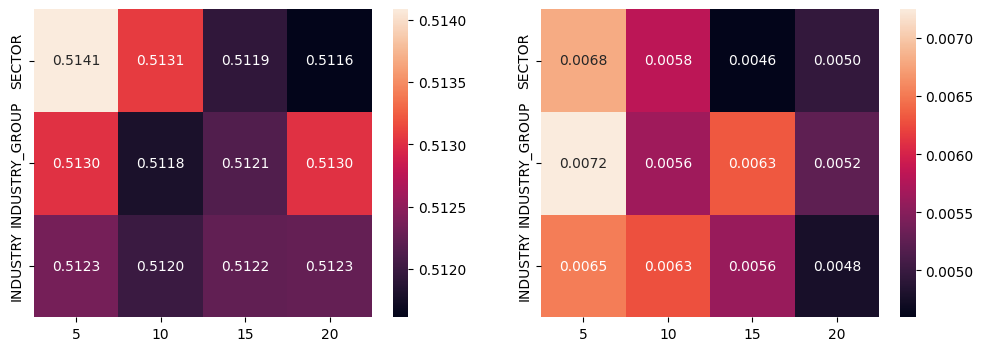

In [12]:
# load outcomes and procsess it

backdates = [5, 10, 15, 20]
rel_cat_cols = ['SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY']

acc_df = pd.DataFrame(index=rel_cat_cols, columns=backdates, dtype=float)
std_df = pd.DataFrame(index=rel_cat_cols, columns=backdates, dtype=float)

for backdate_range, used_oh_col in product(backdates, rel_cat_cols):
    experiment_name = f'oh-{used_oh_col}_daysback-{backdate_range}'
    results_df = pd.read_csv(output_storage_path / f'{experiment_name}.csv')
    acc_df.loc[used_oh_col, backdate_range] = results_df['accuracy'].mean()
    std_df.loc[used_oh_col, backdate_range] = results_df['accuracy'].std()
    
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(acc_df, annot=True, fmt='.4f', ax=axes[0])
sns.heatmap(std_df, annot=True, fmt='.4f', ax=axes[1])
plt.show()

# Pick and train the best model

In [17]:
EPOCHS = 100
BATCH_SIZE = 64
SEED = 42
VAL_SPLIT = 0.1

best_backdate = 10
best_cat_col = 'INDUSTRY'

bestmodel_exp_name = f'best_model_{best_cat_col}-{best_backdate}days'

chosen_field_oh, ohencoder = column2onehot(train, best_cat_col)
with open(output_storage_path / f'{bestmodel_exp_name}_ohencoder.pkl', 'wb') as f:
    pickle.dump(ohencoder, f)
    
numerical_columns = [f'RET_{i+1}' for i in range(best_backdate)] + [f'VOLUME_{i+1}' for i in range(best_backdate)]
oh_columns = list(chosen_field_oh.columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)
dates_arr = train['DATE']
x_df = x_df[numerical_columns + oh_columns] # assert order

X = x_df.values
Y = train['RET'].astype(int).values

model_checkpoint, model_stats_df = full_dataset_training(
    X=X, Y=Y,
    numerical_columns=numerical_columns,
    output_storage_path=output_storage_path,
    bestmodel_exp_name=bestmodel_exp_name,
    val_split=VAL_SPLIT,
    dropout_rate=[0.4, 0.4, 0.4],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    seed=SEED,
    split_type='date',
    date_array=dates_arr,
    print_every_epoch=PRINT_EVERY,
)

/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_2409/1472943882.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


12:46:36	  -- Epoch 2: 	Training Loss = 0.6924 | Training Accuracy = 0.5171 | Validation Loss = 0.6934 | Validation Accuracy = 0.5052
12:47:18	  -- Epoch 4: 	Training Loss = 0.6916 | Training Accuracy = 0.5242 | Validation Loss = 0.6940 | Validation Accuracy = 0.5047
12:48:00	  -- Epoch 6: 	Training Loss = 0.6910 | Training Accuracy = 0.5277 | Validation Loss = 0.6954 | Validation Accuracy = 0.5052
12:48:43	  -- Epoch 8: 	Training Loss = 0.6908 | Training Accuracy = 0.5304 | Validation Loss = 0.6949 | Validation Accuracy = 0.5029
12:49:25	  -- Epoch 10: 	Training Loss = 0.6904 | Training Accuracy = 0.5312 | Validation Loss = 0.6938 | Validation Accuracy = 0.5096
12:50:08	  -- Epoch 12: 	Training Loss = 0.6903 | Training Accuracy = 0.5325 | Validation Loss = 0.6940 | Validation Accuracy = 0.5060
12:50:50	  -- Epoch 14: 	Training Loss = 0.6902 | Training Accuracy = 0.5328 | Validation Loss = 0.6948 | Validation Accuracy = 0.5023
12:51:33	  -- Epoch 16: 	Training Loss = 0.6900 | Training 

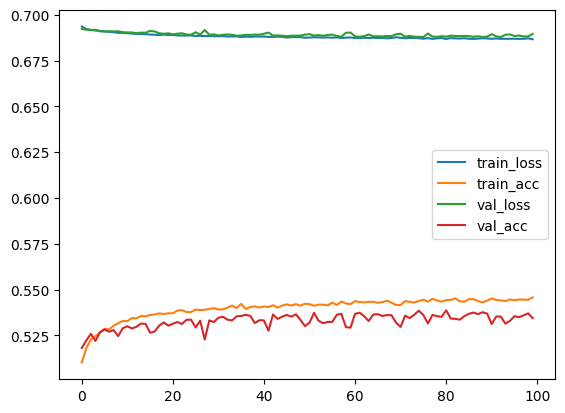

In [14]:
model_stats_df.plot()
plt.show()

# Run the trained model on eval set

In [15]:
# setup variables
best_backdate = 10
best_cat_col = 'INDUSTRY'
bestmodel_exp_name = f'best_model_{best_cat_col}-{best_backdate}days'
print(bestmodel_exp_name)
checkpoint_path = output_storage_path / f'{bestmodel_exp_name}.pt'

# preprocess data
with open(output_storage_path / f'{bestmodel_exp_name}_ohencoder.pkl', 'rb') as f:
    ohencoder = pickle.load(f)
    
eval_chosen_field_oh, _ = column2onehot(train, best_cat_col, ohencoder=ohencoder)
numerical_columns = [f'RET_{i+1}' for i in range(best_backdate)] + [f'VOLUME_{i+1}' for i in range(best_backdate)]
oh_columns = list(eval_chosen_field_oh.columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_eval_df = test[numerical_columns].join(eval_chosen_field_oh).fillna(0)
x_eval_df = x_eval_df[numerical_columns + oh_columns] # assert order

X_eval = x_eval_df.values

preds = load_model_and_predict(checkpoint_path, X_eval, numerical_columns, batch_size=32)

test_with_preds = test.copy()
test_with_preds['preds'] = preds
test_with_preds['RET'] = test_with_preds['preds'] > 0.5
test_with_preds

best_model_INDUSTRY-10days


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_28547/1617654781.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_eval_df = test[numerical_columns].join(eval_chosen_field_oh).fillna(0)
/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/nn_utils.py:400: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpicklin

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,preds,RET
ID,,,,,,,,,,,,,,,,,,,,,
418595,2,0,37,12,5,94,0.020208,0.146176,0.010059,0.224756,...,-0.001035,-0.416533,-0.000148,-0.004548,-0.000148,-0.161792,0.016997,-0.007221,0.533923,True
418596,2,1,15,4,3,37,0.009134,-0.251631,0.021913,-0.712515,...,-0.001544,-0.408979,0.001546,0.396372,-0.007875,-0.431760,0.001742,-0.574228,0.529249,True
418597,2,4,57,20,8,142,0.005008,-0.115845,0.005914,-0.107441,...,0.011481,-0.536967,0.009520,-0.368585,0.000000,0.022713,-0.002066,-0.207362,0.501574,True
418598,2,5,35,12,5,91,0.015370,-0.090295,-0.013738,0.048465,...,0.037018,0.665132,-0.003097,0.141991,-0.008191,-0.172382,0.005145,-0.353172,0.494081,False
418599,2,6,57,20,8,142,0.011419,-0.289027,0.022807,-0.262690,...,0.004304,-0.506291,-0.026469,-0.280666,0.010743,0.365773,-0.011134,0.933284,0.482629,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617019,222,5707,52,18,7,122,0.010188,-0.476830,-0.006419,-0.534137,...,0.019115,0.361119,-0.002090,-0.132224,0.015389,-0.014298,-0.008680,0.128657,0.520971,True
617020,222,5710,33,10,4,83,-0.000838,-0.063269,-0.026928,0.532781,...,0.032965,0.108639,0.013488,-0.458271,0.019894,-0.353293,0.013513,-0.219671,0.519737,True
617021,222,5714,49,17,7,113,0.005941,-0.506350,-0.016363,-0.173802,...,0.002121,1.087437,-0.012910,1.791362,-0.057857,6.330687,-0.000493,1.175063,0.501884,True


# Save the outcomes

In [16]:
test_with_preds['RET'].reset_index().to_csv(output_storage_path / 'naive_nn_asulik_submission2.csv', index=False)